In [1]:
import numpy as np
import torch
import time
import pandas as pd
from tqdm.notebook import tqdm
import iisignature

import sigkernel

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
          'figure.figsize': (16, 16),
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14}
pylab.rcParams.update(params)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dependence on length of paths

In [13]:
t_pde_cpu = []
t_pde_gpu = []

lengths = range(100, 500, 10)
N, dim = 5, 2
tol = 1e-3

for l in tqdm(lengths):
    
    # generate paths
    x = np.array([sigkernel.brownian(l-1, dim).astype(np.float64) for n in range(N)])
    y = np.array([sigkernel.brownian(l-1, dim).astype(np.float64) for n in range(N)])
    x_cpu = torch.tensor(x, dtype=torch.float64, device='cpu')
    y_cpu = torch.tensor(y, dtype=torch.float64, device='cpu')
    x_gpu = torch.tensor(x, dtype=torch.float64, device='cuda')
    y_gpu = torch.tensor(y, dtype=torch.float64, device='cuda')
    
    # true answer
#     sig_x = iisignature.sig(x, 12)
#     sig_y = iisignature.sig(y, 12)
#     true_answer = np.array([1. + np.dot(s_x,s_y) for s_x,s_y in zip(sig_x,sig_y)])
    static_kernel = sigkernel.LinearKernel()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=5)
    true_answer = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
        
    # sig PDE CPU
    k = 1e8*np.ones(N)
    o = -1
    while (np.abs(k - true_answer) > tol).all():
        o += 1
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
        k = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
    t = time.time()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
    _ = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
    t_pde_cpu.append(time.time()-t)
    
    # sig PDE GPU
    k = 1e8*np.ones(N)
    o = -1
    while (np.abs(k - true_answer) > tol).all():
        o += 1
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
        k = signature_kernel.compute_kernel(x_gpu, y_gpu).cpu().numpy()
    t = time.time()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
    _ = signature_kernel.compute_kernel(x_gpu, y_gpu).cpu().numpy()
    t_pde_gpu.append(time.time()-t)

  0%|          | 0/40 [00:00<?, ?it/s]

In [40]:
t_pde_cpu_ = []
t_pde_gpu_ = []

dims = range(10, 3000, 50)
N, l = 5, 10
tol = 1e-3

for dim in tqdm(dims):
    
    # generate paths
    x = np.array([sigkernel.brownian(l-1, dim).astype(np.float64) for n in range(N)])
    y = np.array([sigkernel.brownian(l-1, dim).astype(np.float64) for n in range(N)])
    x_cpu = torch.tensor(x, dtype=torch.float64, device='cpu')
    y_cpu = torch.tensor(y, dtype=torch.float64, device='cpu')
    x_gpu = torch.tensor(x, dtype=torch.float64, device='cuda')
    y_gpu = torch.tensor(y, dtype=torch.float64, device='cuda')
    
    # true answer
    static_kernel = sigkernel.LinearKernel()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=5)
    true_answer = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
    
    # sig PDE CPU
    k = 1e8*np.ones(N)
    o = -1
    while (np.abs(k - true_answer) > tol).all():
        o += 1
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
        k = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
    t = time.time()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
    _ = signature_kernel.compute_kernel(x_cpu, y_cpu).numpy()
    t_pde_cpu_.append(time.time()-t)
    
    # sig PDE GPU
    k = 1e8*np.ones(N)
    o = -1
    while (np.abs(k - true_answer) > tol).all():
        o += 1
        signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
        k = signature_kernel.compute_kernel(x_gpu, y_gpu).cpu().numpy()
    t = time.time()
    signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=o)
    _ = signature_kernel.compute_kernel(x_gpu, y_gpu).cpu().numpy()
    t_pde_gpu_.append(time.time()-t)

  0%|          | 0/60 [00:00<?, ?it/s]

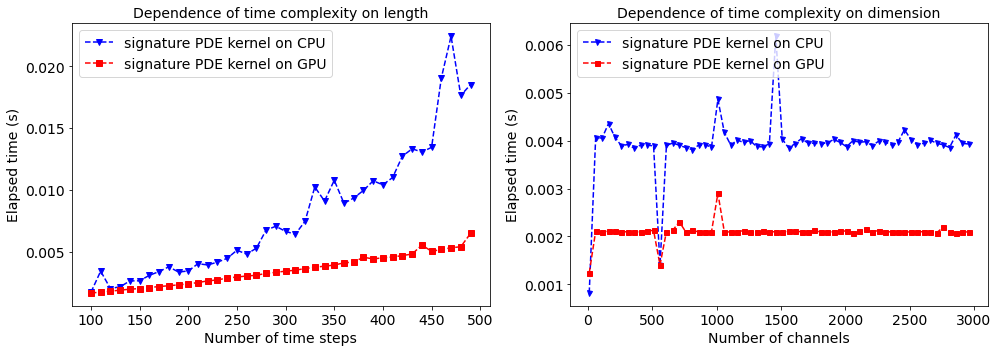

In [51]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

ax=plt.subplot(1, 2, 1)
ax.plot(lengths, t_pde_cpu, label='signature PDE kernel on CPU', ls='--', marker='v', markersize=6, c='b')
ax.plot(lengths, t_pde_gpu, label='signature PDE kernel on GPU', ls='--', marker='s', markersize=6, c='r')

ax.set_title('Dependence of time complexity on length')
ax.set_xlabel('Number of time steps')
ax.set_ylabel('Elapsed time (s)')
ax.legend()
# ax.set_ylim(0,2.5)
ax.legend(loc="upper left")
# ax.grid(True)

ax=plt.subplot(1, 2, 2)
ax.plot(dims, t_pde_cpu_, label='signature PDE kernel on CPU', ls='--', marker='v', markersize=5, c='b')
ax.plot(dims, t_pde_gpu_, label='signature PDE kernel on GPU', ls='--', marker='s', markersize=5, c='r')

ax.set_title('Dependence of time complexity on dimension')
ax.set_xlabel('Number of channels')
ax.set_ylabel('Elapsed time (s)')
ax.legend()
# ax.set_ylim(0,2.5)
ax.legend(loc="upper left")
# ax.grid(True)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.tight_layout()
plt.savefig('../pictures/perfomance.png')
plt.show()